In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
from wikipediaapi import Wikipedia


import matplotlib.pyplot as plt

/home/agherasie/anaconda3/envs/discover/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !python3 -m spacy download en_core_web_lg

In [3]:
# Load spacy English languague model
NER = spacy.load("en_core_web_lg")

In [4]:
wiki = Wikipedia('en')

In [5]:
class Page:
    def __init__(self, title, minimum_mentions):
        self.page = wiki.page(title)
        self.page_doc = NER(self.page.text)

        entities = {}
        for sent in self.page_doc.sents:
            for ent in sent.ents:
                if ent.text not in entities:
                    entities[ent.text] = 1
                else:
                    entities[ent.text] += 1

        self.top_neighbours = {}
        for link in self.page.links:
            for entity, count in entities.items():
                if link == entity and count >= minimum_mentions:
                    self.top_neighbours[link] = count

In [6]:
index = Page('Game_of_Thrones', 4)

index.top_neighbours

{'Blu-ray': 8,
 'D. B. Weiss': 5,
 'Daenerys Targaryen': 4,
 'David Benioff': 5,
 'Dubrovnik': 8,
 'Entertainment Weekly': 5,
 'Essos': 4,
 'George R. R. Martin': 7,
 'HBO': 53,
 'Lannister': 4,
 'Northern Ireland': 10,
 'Stephen Dillane': 4,
 'Westeros': 11}

In [8]:
from tqdm import tqdm

neighbors = {}
def recursive_neighbors(page, depth, initial_depth):
    if depth <= 0:
        return
    for neighbor in page.top_neighbours.keys():
        for _ in range(initial_depth - depth):
            print(end='\t')
        print(f'{neighbor}, {depth}')
        new_page = Page(neighbor, 4)
        neighbors[neighbor] = new_page
        recursive_neighbors(new_page, depth-1, initial_depth)

recursive_neighbors(index, 2, 2)

Blu-ray, 2
	1080p, 1
	AVCHD, 1
	Blu-ray, 1
	Blu-ray 3D, 1
	Japan, 1
	Panasonic, 1
	Paramount Pictures, 1
	PlayStation 3, 1
	PlayStation 4, 1
	PlayStation 5, 1
	Sony, 1
	TDK, 1
	Toshiba, 1
	VC-1, 1
	Warner Bros., 1
	Xbox One, 1
D. B. Weiss, 2
	Game of Thrones, 1
	HBO, 1
	Netflix, 1
Daenerys Targaryen, 2
	Astapor, 1
	Dothraki, 1
	Game of Thrones, 1
	HBO, 1
	Illyrio Mopatis, 1
	Khal Drogo, 1
	Meereen, 1
	Missandei, 1
	Qarth, 1
	Tyrion Lannister, 1
	Westeros, 1
	Yunkai, 1
David Benioff, 2
	Game of Thrones, 1
	HBO, 1
	Netflix, 1
Dubrovnik, 2
	Croatia, 1
	Dalmatia, 1
	Latin, 1
	Venice, 1
Entertainment Weekly, 2
Essos, 2
	A Clash of Kings, 1
	A Dance with Dragons, 1
	A Game of Thrones, 1
	Bantam Books, 1
	Casterly Rock, 1
	Croatia, 1
	Dothraki, 1
	George R. R. Martin, 1
	HBO, 1
	Highgarden, 1
	House Arryn, 1
	House Baratheon, 1
	Iceland, 1
	Malta, 1
	Melisandre, 1
	Morocco, 1
	Ned Stark, 1
	Northern Ireland, 1
	Spain, 1
	Westeros, 1
	Winterfell, 1
George R. R. Martin, 2
	A Song of Ice and Fir

In [9]:
relationships = []

for page in [index, *neighbors.values()]:
    for neighbor, value in page.top_neighbours.items():
        relationships.append({'source': page.page.title, 'target': neighbor, 'value': value})

relationship_df = pd.DataFrame(relationships)
relationship_df

,source,target,value
0,Game of Thrones,Blu-ray,8
1,Game of Thrones,D. B. Weiss,5
2,Game of Thrones,Daenerys Targaryen,4
3,Game of Thrones,David Benioff,5
4,Game of Thrones,Dubrovnik,8
...,...,...,...
2323,Hamlet,Hamlet,237
2324,Hamlet,Norway,6
2325,Hamlet,Oedipus Rex,4
2326,Hamlet,Ophelia,34


In [10]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

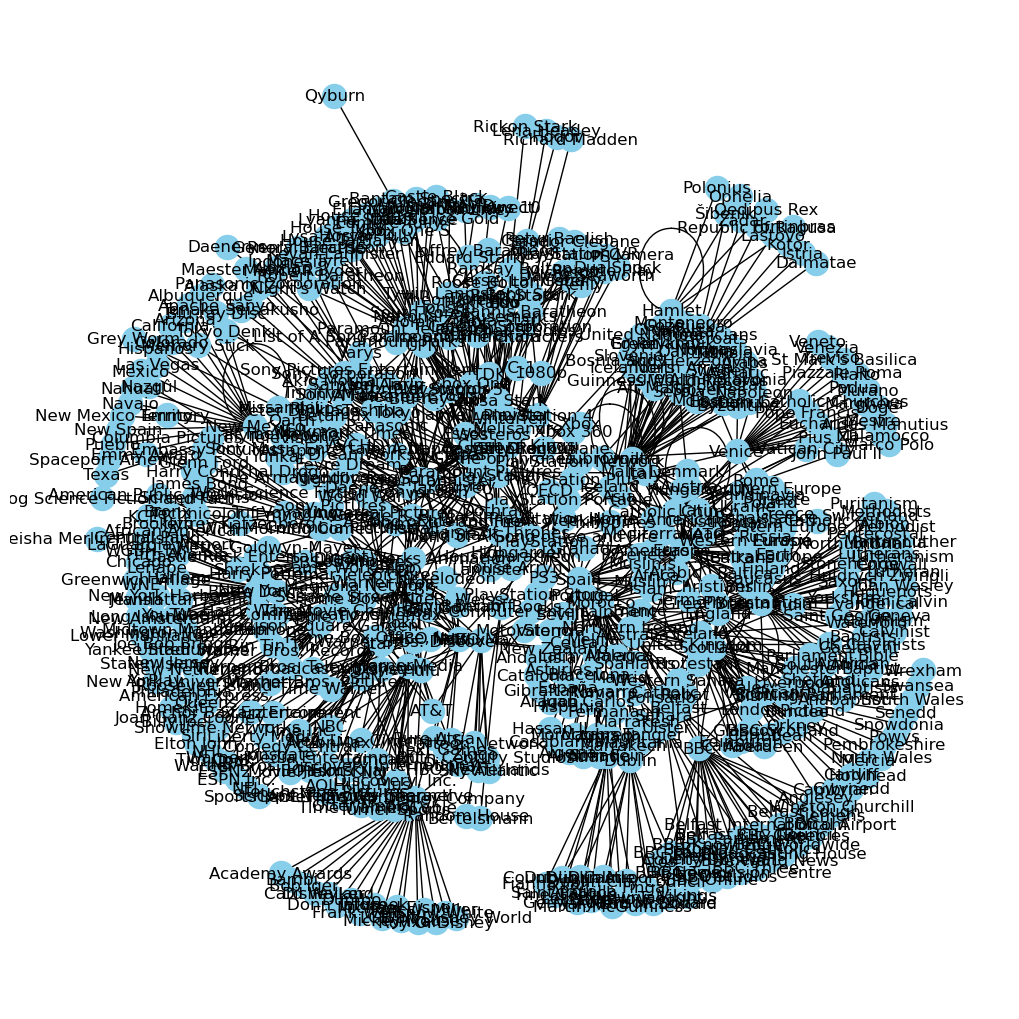

In [11]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [12]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("hotd.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
